# A simple example: inelastic scattering

Let’s start by running an inelastic scattering reaction on {{bfrescox}} using a canonical system from the [{{fresco}}](https://www.fresco.org.uk/examples/index.html) examples: $^{4}$ He inelastic scattering on a $^{12}$ C target at a laboratory energy of 100 MeV. Note, however, that we are running a full closed-couplings inelastic scattering calculation, whereas the example in [{{fresco}}](https://www.fresco.org.uk/examples/index.html) uses the Distorted Wave Born Approximation. 

Just like for elastic scattering, the {{bfrescox}} package contains a built-in **template** generator to generage a full {{frescox}} **input file**. For the moment, the built-in capabilities allow only for inclusion of target deformations in the calculation, for projectile deformations and other more complex reaction systems involving coupled-channels, we refer the use to the User-Defined-Template guide. 

In [19]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import inspect
import pandas as pd
import json

with open("MatplotlibEsthetics.json", "r") as fptr:
    esthetics = json.load(fptr)

plt.style.use(esthetics["style"])
FONTSIZE      = esthetics["fontsize"]
TICK_FONTSIZE = esthetics["tick_fontsize"]
MARKERSIZE    = esthetics["markersize"]
LINEWIDTH     = esthetics["linewidth"]

In [20]:
# Folder to which all frescox input/output files will be written to
EXAMPLE_DIR = Path.cwd().joinpath("12C_4He_inelastic_example")
if EXAMPLE_DIR.exists():
    shutil.rmtree(EXAMPLE_DIR)
os.mkdir(EXAMPLE_DIR)

## Generating the template

Just as was the case for elastic scattering, running {{bfrescox}} utilizes template input files, which is an otherwise valid {{frescox}} input file, with certain numerical values replaced with strings like `@param_name@`. The function `Configuration.from_template` takes in a file path to such a template, and a dictionary of the parameter values to fill in (e.g. `{"param_name" : 12}`, which, as one might guess, would replace `@param_name@` with the number 12), and returns a `Configuration` instance, which specifies a valid {{frescox}} input.

One can then use `bfrescox.run_simulation` to run it, and `bfrescox.parse_fort16` to parse the resulting cross sections. This is exactly what we will be doing in this example!

However, doing all this requires having a valid {{frescox}} input file template already. Alternatively, {{bfrescox}} can generate such a template based on a users problem specification (currently, this is only supported for elastic and inelastic scattering). We will now demonstrate this capability using `bfrescox.generate_inelastic_template`.

So, to summarize, the steps we will follow are:
1. generate a template using `bfrescox.generate_inelastic_template`
2. fill in the template to generate a valid {{frescox}} configuration using `bfrescox.Configuration.from_template`
3. run {{frescox}} for this configuration using `bfrescox.run_simulation`
4. parse the output using `bfrescox.parse_fort16`

### Step 1: create the {{bfrescox}} template

`bfrescox.generate_inelastic_template` creates an inelastic template file based on a system specification which leaves as template parameters all of the parameters related to the target-projectile interaction.

In [21]:
import bfrescox

system_spec = {
          "target_mass_amu" : 12,
          "target_atomic_number" : 6,
          "projectile_mass_amu" : 4,
          "projectile_atomic_number" : 2,
          "projectile_spin" : 0,
          "E_lab_MeV": 100,
          "J_tot_min": 0.0,
          "J_tot_max": 40.0,
          "target_state_spins": [0.0, 2.0],
          "target_state_energies_MeV": [0, 4.43],     
          "target_state_parities": [1, 1],       
          "multipoles": [2],         
          "R_match_fm": 20.0,
          "step_size_fm": 0.05,
          "reaction_name": "alpha+c12 -> alpha+c12* @ 100 MeV; nuc def"
        }

TEMPLATE_PATH = EXAMPLE_DIR.joinpath("12C_4He_inelastic_example.template")
bfrescox.generate_inelastic_template(
    TEMPLATE_PATH, **system_spec
)

We now have generated the {{bfrescox}} **template** for the inelastic system! Let's see what this looks like.

In [22]:
with open(TEMPLATE_PATH, "r") as temp:
    generated_content = temp.read()

print("Generated Bfrescox Inelastic Template:")
print("-----------------------------------")
print(generated_content)

Generated Bfrescox Inelastic Template:
-----------------------------------
alpha+c12 -> alpha+c12* @ 100 MeV; nuc def
NAMELIST
&FRESCO hcm=0.050000000 rmatch=20.000000000
    jtmin=0.0 jtmax=40.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=2 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=100.000000000 treneg=1 /

 &PARTITION namep='projectile' massp=4.000000000 zp=2.000000000
            namet='target'   masst=12.000000000 zt=6.000000000 qval=0.0 nex=2  /
 &STATES jp=0.0 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0.000000000 /
 &STATES copyp=1 cpot=1 jt=2.0 bandt=1 et=4.430000000 /
&partition /

 &POT kp=1 ap=4.000000000 at=12.000000000 rc=@rC@  /
 &POT kp=1 type=1  p1=@V@ p2=@r@ p3=@a@ p4=@W@ p5=@rw@ p6=@aw@ /
&POT kp=1 type=11 p2=@delta_2@ /
 &POT kp=1 type=2  p1=@Vs@ p2=@rs@ p3=@as@ p4=@Ws@ p5=@rws@ p6=@aws@ /
&POT kp=1 type=11 p2=@delta_2@ /
 &POT kp=1 type=3  p1=@Vso@ p2=@rso@ p3=@aso@ p4=@Wso@ p5=@rwso@ p6=@awso@ /

 &pot /
 &overlap /
 &coupling 

Great! All system quantities are now defined and in place for the reaction we want to run. The parameter **placeholders** are put in place, each one is labeled as `@<parameter name>@` in the **template**.

The generated template has filled in our problem spefication, but left as template parameters the parameters of the target-projectile interaction. This includes the parameters `V`, `r`, `a`; users familiar with optical potentials will immediately recognize these as depth, reduced radii, and diffuseness, respecitvely, of a Woods-Saxon potential. The other parameters similarily specify the imaginary part of this potential (`W`, `rw`, `aw`), the real and imaginary surface-peaked potentials (`Vs`, `rs`, `as`, `Ws`, `rws`, `aws`), the real and imaginary spin-orbit potential (`Vso`, `rso`, `aso`, `Wso`, `rwso`, `awso`), and the reduced Coulomb radius `rC`. 

Note that for inelastic scattering we also have deformation strength parameters. In this case inside our `system spec` dictionary we have have included `"multipoles": [2]`. Therefore the only deformation parameter that appears is `delta_2`. Includin higher order multipoles, `"multipoles": [2,3,..]` will dynamically generate deformation strength **placeholders** `delta_2`, `delta_3`, ... in the template.

Using `generate_inelastic_template` thus makes it easy to set up a fitting or uncertainty-quantification problem relating to these interaction parameters.


#### Note for {{frescox}} users:
All the template parameters in our generated template are in the `&POT` namelists of the input file. {{frescox}} users will be familiar with how this speficiation works, others can find the full documenation here: https://www.fresco.org.uk/xinput7a/frescox-namelist-manual/node8.html.



### Step 2: fill in the template

If you wanted to, you could fill in specific interaction parameters in this template by hand. {{bfrescox}} gives us the functionality to fill them in in the `Configuration` class.


In [23]:
elastic_optical_model_parameters = {
    "rC":  1.2, "delta_2": 1.3,
    "V":  40.0, "r":   1.2, "a":   0.65, "W":  10.0, "rw":   1.2, "aw":   0.5,
    "Vs":  0,   "rs":  1.2, "as":  0.5,  "Ws":  0,   "rws":  1.2, "aws":  0.5,
    "Vso": 0,   "rso": 1.0, "aso": 0.65, "Wso": 0,   "rwso": 1.0, "awso": 0.65   
}

cfg = bfrescox.Configuration.from_template(
    TEMPLATE_PATH,
    EXAMPLE_DIR.joinpath("frescox.in"),
    elastic_optical_model_parameters,
    overwrite=True,
)

We now have generated a fully valid {{frescox}} **input file** from the **template**! Any working {{frescox}} installation should be able to run this.

Let's see what this looks like.

In [24]:
with open(EXAMPLE_DIR.joinpath("frescox.in"), "r") as input:
    generated_content = input.read()

print("Generated Frescox Input:")
print("-----------------------------------")
print(generated_content)

Generated Frescox Input:
-----------------------------------
alpha+c12 -> alpha+c12* @ 100 MeV; nuc def
NAMELIST
&FRESCO hcm=0.050000000 rmatch=20.000000000
    jtmin=0.0 jtmax=40.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=2 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=100.000000000 treneg=1 /

 &PARTITION namep='projectile' massp=4.000000000 zp=2.000000000
            namet='target'   masst=12.000000000 zt=6.000000000 qval=0.0 nex=2  /
 &STATES jp=0.0 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0.000000000 /
 &STATES copyp=1 cpot=1 jt=2.0 bandt=1 et=4.430000000 /
&partition /

 &POT kp=1 ap=4.000000000 at=12.000000000 rc=1.200000000  /
 &POT kp=1 type=1  p1=40.000000000 p2=1.200000000 p3=0.650000000 p4=10.000000000 p5=1.200000000 p6=0.500000000 /
&POT kp=1 type=11 p2=1.300000000 /
 &POT kp=1 type=2  p1=0.000000000 p2=1.200000000 p3=0.500000000 p4=0.000000000 p5=1.200000000 p6=0.500000000 /
&POT kp=1 type=11 p2=1.300000000 /
 &POT kp=1 type=3  p1=0.

Awesome! We have now generated the {{frescox}} inelastic **input file** using the built-in {{bfrescox}} template and input generators.

## Step 3: Running {{frescox}}

Now that we have generated the {{frescox}} **input file**, running the elastic scattering calculation is extremely easy!

In [25]:
bfrescox.run_simulation(cfg, EXAMPLE_DIR.joinpath("frescox.out"), cwd=EXAMPLE_DIR)

Done! All we need to do is parse the results and extract the physical quantities we want. Let's focus on extracting the cross sections from the **output files**.



## Step 4: Parsing the output
For this particular scattering system setup, {{frescox}} writes the the elastic channel and inelastic channel cross sections fo the **fort.16** file.  Let's extract those cross sections for our example case as a DataFrame.


In [26]:
fort16_df = bfrescox.parse_fort16(EXAMPLE_DIR.joinpath("fort.16"))
elastic_channel_xs = fort16_df["channel_1"]
inelastic_channel_xs = fort16_df["channel_2"]

Let's see what the cross sections look like!

In [27]:
# Note that ration to Rutherford is used  for the elastic channel, 
display(elastic_channel_xs.head())
display(inelastic_channel_xs.head())

,Theta,sigma
0,0.01,1.0000
1,1.00,0.8527
2,2.00,0.5887
3,3.00,0.5779
4,4.00,0.9953


,Theta,sigma
0,0.0,64.18
1,1.0,61.02
2,2.0,53.42
3,3.0,45.98
4,4.0,43.79


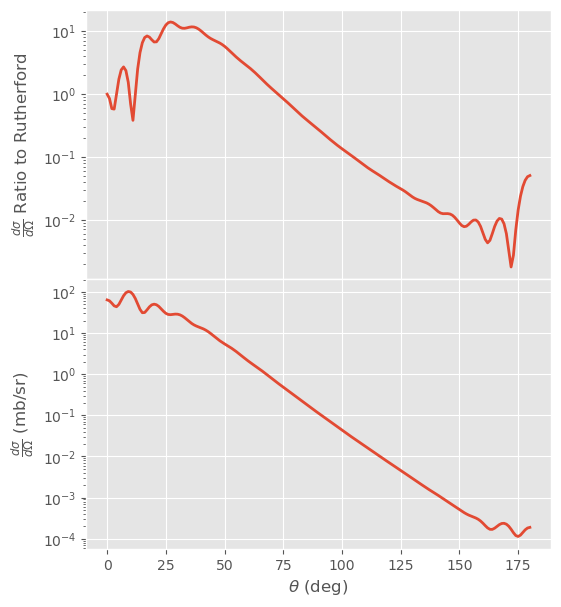

In [30]:
# Plot the results
angles = elastic_channel_xs["Theta"].to_numpy()
# load the cross section values to benchmark the inelastic and elastic results
elastic = elastic_channel_xs["sigma"].to_numpy()
inelastic = inelastic_channel_xs["sigma"].to_numpy()


# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Global font size settings for ticks
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)  # increase tick font size
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)  # optional minor tick size


ax1.plot(angles, elastic, lw=LINEWIDTH)
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ Ratio to Rutherford", fontsize=FONTSIZE)


ax2.plot(angles, inelastic, lw=LINEWIDTH)
ax2.set_yscale('log')
ax2.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=FONTSIZE)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
ax1.text(50.0, 1e-4, r"$E_{lab} = 100$ MeV",
        fontsize=FONTSIZE, color='black')


plt.show()